# Poisson rSLDS 
## Behaving dataset
## Stim is as cue, system should come back to rest before lift 
## Fitting model from cue to grab, k=2

In [1]:
import ssm
from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from real_spike.utils import *

from scipy.ndimage import gaussian_filter1d

import random
import h5py

import fastplotlib as fpl
from ipywidgets import IntSlider, VBox, Layout, Select, HBox

from PIL import Image
%matplotlib inline

Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅,Intel(R) Arc(tm) Graphics (MTL),IntegratedGPU,Vulkan,Mesa 25.0.4
✅ (default),NVIDIA GeForce RTX 4060 Laptop GPU,DiscreteGPU,Vulkan,565.77
❗ limited,"llvmpipe (LLVM 19.1.7, 256 bits)",CPU,Vulkan,Mesa 25.0.4 (LLVM 19.1.7)
❌,Mesa Intel(R) Arc(tm) Graphics (MTL),IntegratedGPU,OpenGL,4.6 (Core Profile) Mesa 25.0.4


Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.


In [2]:
path = f"/home/clewis/repos/realSpike/data/behavior/rb50_20250125/"

In [3]:
video_path =  Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250125/videos/")

# Get data

In [4]:
f = h5py.File("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250125/MAT_FILES/rb50_20250125_datastruct_pt3.mat", 'r')
data = f['data']
print(data.keys())

<KeysViewHDF5 ['aligned_cue_rec_time', 'aligned_laser_rec_time', 'any', 'chan_spk', 'cue', 'cue_rec_time', 'cue_trial_time', 'depth_spk', 'field_id', 'field_size', 'full_field', 'grab', 'grab_ms', 'laser', 'laser_rec_time', 'laser_trial_time', 'lift', 'lift_ms', 'lift_rec_time', 'mouth', 'mouth_ms', 'no_success', 'pattern_fill', 'pattern_id', 'pattern_xy', 'plift', 'plift_ms', 'single', 'spikes_raw_cue', 'spikes_raw_cue_extended', 'spikes_raw_laser', 'spikes_raw_lift', 'totTime', 'trial_start']>


# Plot the patterns

In [5]:
# visualize the patterns again
pattern_ids = list(np.unique(data['pattern_id'][:]))
len(pattern_ids)

30

In [6]:
from scipy.ndimage import zoom

In [7]:
reshape_size = 12

In [8]:
all_patterns = list()

for p_id in pattern_ids[3:]:
    ix = np.where(data['pattern_id'][:] == p_id)[1][0].astype(np.int32)
    pattern = np.zeros((data['pattern_xy'][0][ix].astype(np.int32), data['pattern_xy'][1][ix].astype(np.int32)))
    # use the pattern fill to set elements to one
    object_ref = f[data['pattern_fill'][ix, 0]]
    for x, y in zip(object_ref[0, :], object_ref[1, :]):
        pattern[x.astype(np.int32)-1, y.astype(np.int32)-1] = 1

    pattern = zoom(pattern, (reshape_size / pattern.shape[0], reshape_size / pattern.shape[1]), order=0)

    all_patterns.append(pattern)


In [9]:
len(all_patterns)

27

# Get single-reach trials

In [10]:
stim_idxs = np.where(data["pattern_id"][:] > 2)[1]
single_reach_idxs = np.where(data["single"][:, 0] == 1)

In [11]:
stim_idxs

array([ 16,  18,  20,  22,  23,  24,  29,  31,  32,  34,  37,  38,  40,
        42,  43,  46,  47,  48,  52,  55,  56,  60,  61,  62,  64,  67,
        68,  70,  71,  73,  76,  77,  78,  82,  83,  86,  89,  90,  92,
        94,  97,  98, 101, 103, 104, 106, 107, 108, 113, 114, 116, 118,
       121, 122, 124, 127, 128, 131, 132, 133, 150, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 188, 189, 190, 191, 192, 193, 194, 195, 196,
       198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
       212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
       225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 237, 238,
       239, 240, 241, 242, 243, 244, 245, 246, 248, 249, 250, 251, 252,
       254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
       267, 268, 269, 270, 271, 272, 273, 274, 275, 277, 278, 27

In [12]:
single_reach_idxs

(array([  2,   6,   7,   9,  10,  12,  13,  14,  15,  18,  20,  21,  23,
         26,  27,  28,  30,  32,  33,  35,  36,  37,  40,  41,  42,  44,
         45,  48,  50,  51,  53,  55,  56,  57,  60,  61,  63,  67,  68,
         70,  75,  78,  80,  83,  84,  86,  96,  97, 100, 101, 102, 103,
        106, 110, 111, 115, 118, 121, 123, 125, 128, 129, 131, 138, 142,
        145, 147, 149]),)

In [13]:
# get no laser trials
behavior_idxs = np.intersect1d(stim_idxs, single_reach_idxs)
behavior_idxs

array([ 18,  20,  23,  32,  37,  40,  42,  48,  55,  56,  60,  61,  67,
        68,  70,  78,  83,  86,  97, 101, 103, 106, 118, 121, 128, 131])

In [14]:
behavior_idxs.shape

(26,)

## Get relevant time information

In [15]:
cue_times = data["aligned_cue_rec_time"][behavior_idxs, :]
lift_times = data["lift_ms"][behavior_idxs, :]
grab_times = data["mouth_ms"][behavior_idxs, :]
(cue_times.shape, lift_times.shape, grab_times.shape)

((26, 1), (26, 1), (26, 1))

## Get the AP.bin file

In [16]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250125/rb50_20250125_g0/rb50_20250125_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250125/rb50_20250125_g0/rb50_20250125_g0_t0.imec0.ap.meta")

In [17]:
meta_data = get_meta(meta_path)

In [18]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 164723792)

## Get conversion params

In [19]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

(vmax, imax, gain)

(0.6, 512.0, 500.0)

# Get the model data

In [20]:
def get_trials(idxs, bin_size):
    
    model_data = list()
    
    for i, j in tqdm(enumerate(idxs)):
        c = data["aligned_cue_rec_time"][j, 0] 
        g = data["grab_ms"][j, 0]
        # 50 ms before cue
        cue_time = int((c - 50) / 1_000 * 30_000)

        # end at 5m after grab 
        end_behavior = int((c + g) / 1_000 * 30_000)

        
        trial = ap_data[:150, cue_time:end_behavior]
    
        # convert to microvolts
        conv_data = 1e6 * trial / vmax / imax / gain
        # high pass filter 
        filt_data = butter_filter(conv_data, 1_000, 30_000)

        # get 1 second before the median 
        m_start = cue_time - (30 * 1000)
        # convert to microvolts, high pass filter
        trial_median = ap_data[:150, m_start:cue_time]
        trial_median = 1e6 * trial_median / vmax / imax / gain
        trial_median = butter_filter(trial_median, 1_000, 30_000)
        
        # calculate the median
        median = np.median(trial_median, axis=1)

        # get spike times
        spike_ixs, counts = get_spike_events(filt_data, median)
        
        a = np.zeros((filt_data.shape[0], filt_data.shape[1]))
    
        for i, sc in enumerate(spike_ixs):
            a[i, sc] = 1
    
        b = bin_size * 30 # 30ms per bin
        binned_spikes = bin_spikes(a, b)

        model_data.append(np.asarray(binned_spikes.T, dtype=int))

    return model_data

In [21]:
bin_size = 5

In [22]:
model_data = get_trials(behavior_idxs, bin_size)

0it [00:00, ?it/s]

In [26]:
model_data[0].shape

(92, 150)

In [27]:
# taking 50ms before cue, need to shift
cue = int(50 / bin_size)

lift = int(data["lift_ms"][18, 0] / bin_size) + cue

grab = int(data["grab_ms"][18, 0] / bin_size) + cue - 1
(lift, grab)

(72, 91)

### Sanity check the time points

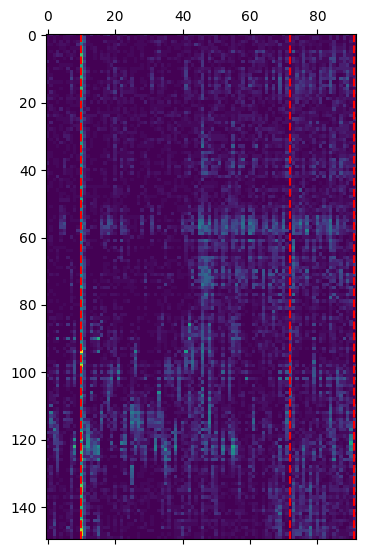

In [28]:
plt.matshow(model_data[0].T)
plt.axvline(cue, c="red", linestyle="--")
plt.axvline(lift, c="red", linestyle="--")
plt.axvline(grab, c="red", linestyle="--")

# Design the input matrix

In [29]:
# get the pattern types

In [30]:
data["pattern_id"]

<HDF5 dataset "pattern_id": shape (1, 440), type "<f8">

In [31]:
p_ids = np.unique(data["pattern_id"][0, behavior_idxs])

p_ids

array([14., 17., 20.])

In [32]:
p_ids.shape

(3,)

## Get colors for plotting

In [35]:
c = {
    14: "blue",
    17: "orange",
    20: "green"
}

In [36]:
len(c)

3

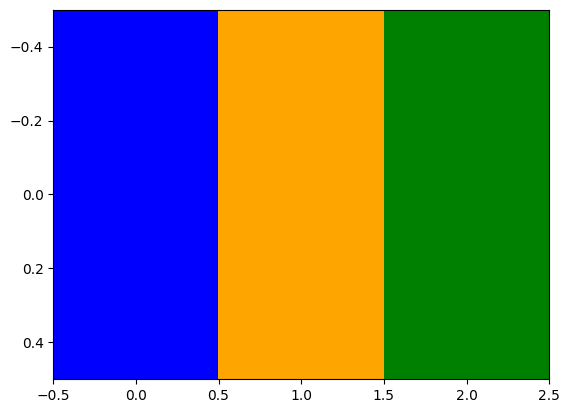

In [37]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(c.values())

plt.imshow(np.arange(len(c)).reshape(1,-1), aspect="auto", cmap=cmap)

# Create encodings 

In [38]:
model_data[1].shape

(88, 150)

In [39]:
import math

In [42]:
inputs = list()
colors = list()
for i, d in zip(stim_idxs, model_data):
    # get the pattern id 
    p_id = int(data["pattern_id"][0][i]) - 3

    colors.append(c[p_id + 3])

    encoding = all_patterns[p_id].ravel() 

    # stack the encoding for every timepoint (each bin)
    nput = np.zeros((d.shape[0], reshape_size**2))

    for z in range(math.ceil(5 / bin_size)):
        nput[int(50 / bin_size) + z] = encoding

    inputs.append(nput)

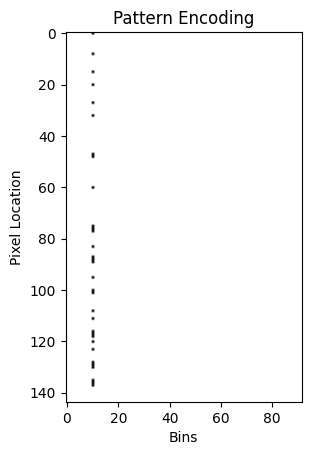

In [44]:
plt.imshow(inputs[0].T, cmap="binary")
plt.title("Pattern Encoding")
plt.xlabel("Bins")
plt.ylabel("Pixel Location")
plt.show()

# Fit the model

In [45]:
state_dim = 3
obs_dim = model_data[0].shape[1] 

plds = ssm.SLDS(N=obs_dim, 
                K=2, 
                D=state_dim, 
                M=144, 
                emissions="poisson", 
                emission_kwargs=dict(link="softplus"),
                dynamics="diagonal_gaussian",
                transitions="recurrent"
               )

elbos, q = plds.fit(model_data, inputs=inputs, method="laplace_em", num_iters=5)

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

# Visualize the results

In [46]:
# plot my elbos

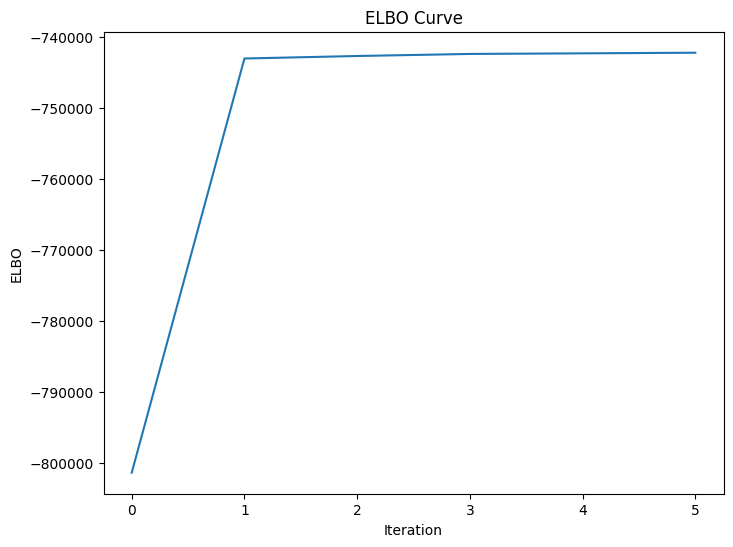

In [46]:
plt.figure(figsize=(8, 6))

plt.plot(elbos)

plt.xlabel("Iteration")
plt.ylabel("ELBO")

plt.title("ELBO Curve")

plt.show()

## Dynamics

In [47]:
As = plds.dynamics.As
As.shape

(2, 3, 3)

In [48]:
b = plds.dynamics.b
b.shape

(3,)

# Eigenvalue Decomposition on `A`

[0.7994194  0.08618007 0.15434995]
[-0.07326812  0.11694928  0.04456928]


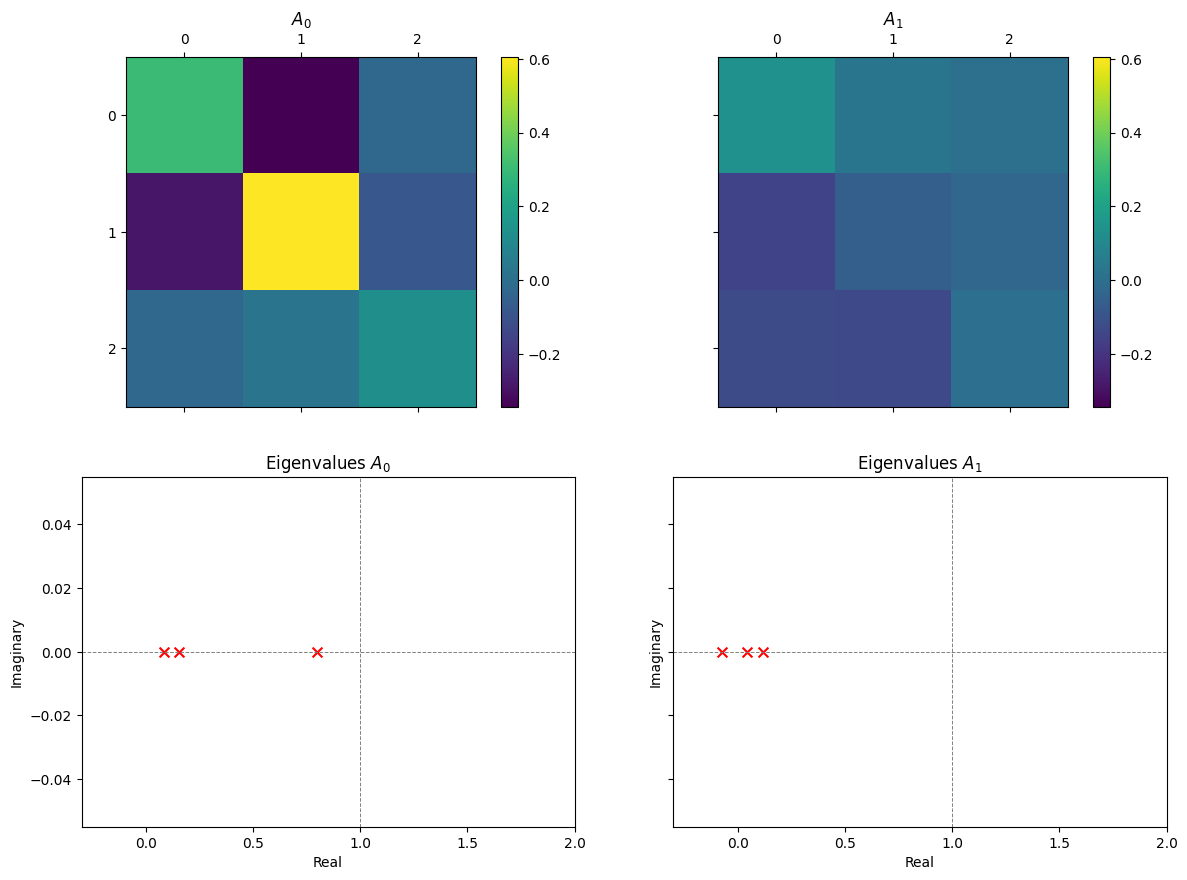

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey="row")

# Flatten axes array for easy iteration
axes = axes.flatten()

vmin = min(mat.min() for mat in [As[0], As[1]])
vmax = max(mat.max() for mat in [As[0], As[1]])

for i in range(2):
    ax = axes[i]
    im = ax.matshow(As[i], vmin=vmin, vmax=vmax)
    ax.set_title(f"$A_{i}$")

    eigvals, eigvecs = np.linalg.eig(As[i])
    axes[i+2].axhline(0, color='gray', linestyle='--', linewidth=0.7)
    axes[i+2].axvline(1, color='gray', linestyle='--', linewidth=0.7)

    print(eigvals.real)
    fig.colorbar(im, ax=ax)

    axes[i+2].scatter(eigvals.real, eigvals.imag, c='red', s=50, marker="x")

    axes[i+2].set_xlim((-0.3, 2))
    
    axes[i+2].set_title(f"Eigenvalues $A_{i}$")
    
    axes[i+2].set_xlabel("Real")
    axes[i+2].set_ylabel("Imaginary")


#fig.colorbar(im, ax=axes[:2]) 

plt.savefig(f"{path}A.png")

plt.show()

# Plot the dynamics 

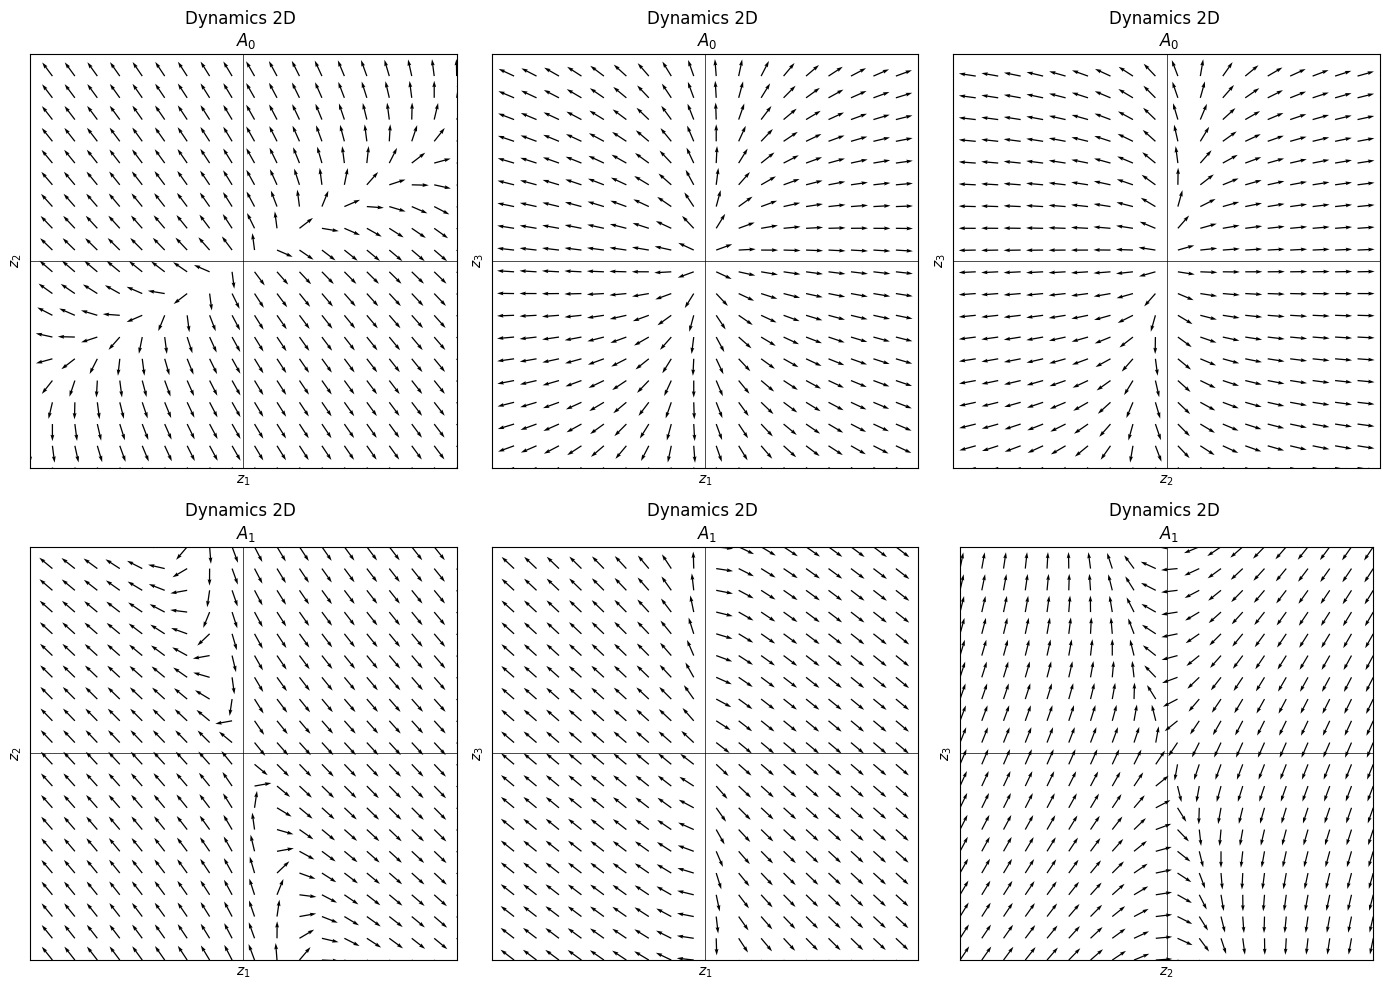

In [50]:
fig, axes = plt.subplots(2, 3, figsize=(14, 10))

axes = axes.flatten()

#A0
A = As[0]

ax = axes[0]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y  
V = A[1,0]*X + A[1,1]*Y 

# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{0}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$")


A = As[0][[0, 2], :][:, [0, 2]]
ax = axes[1]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y  
V = A[1,0]*X + A[1,1]*Y 
# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{0}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_3$")


A = As[0][[1, 2], :][:, [1, 2]]
ax = axes[2]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y 
V = A[1,0]*X + A[1,1]*Y

# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{0}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$z_2$")
ax.set_ylabel("$z_3$")

#A1
A = As[1]

ax = axes[0+3]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y  
V = A[1,0]*X + A[1,1]*Y 

# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{1}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$")


A = As[1][[0, 2], :][:, [0, 2]]
ax = axes[1+3]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y  
V = A[1,0]*X + A[1,1]*Y

# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{1}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_3$")


A = As[1][[1, 2], :][:, [1, 2]]
ax = axes[2+3]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y  
V = A[1,0]*X + A[1,1]*Y 

# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{1}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$z_2$")
ax.set_ylabel("$z_3$")

plt.gca().set_aspect('equal')

plt.tight_layout()

plt.savefig(f"{path}dynamics2.png")
plt.show()

In [51]:
from matplotlib.patches import Patch

In [52]:
state_means = q.mean_continuous_states

In [55]:
custom_patches = [Patch(facecolor=c[j], edgecolor='black', label=f'{int(j)}') for i, j in enumerate(p_ids)]

In [56]:
p_ids

array([14., 17., 20.])

# Plot the state means 

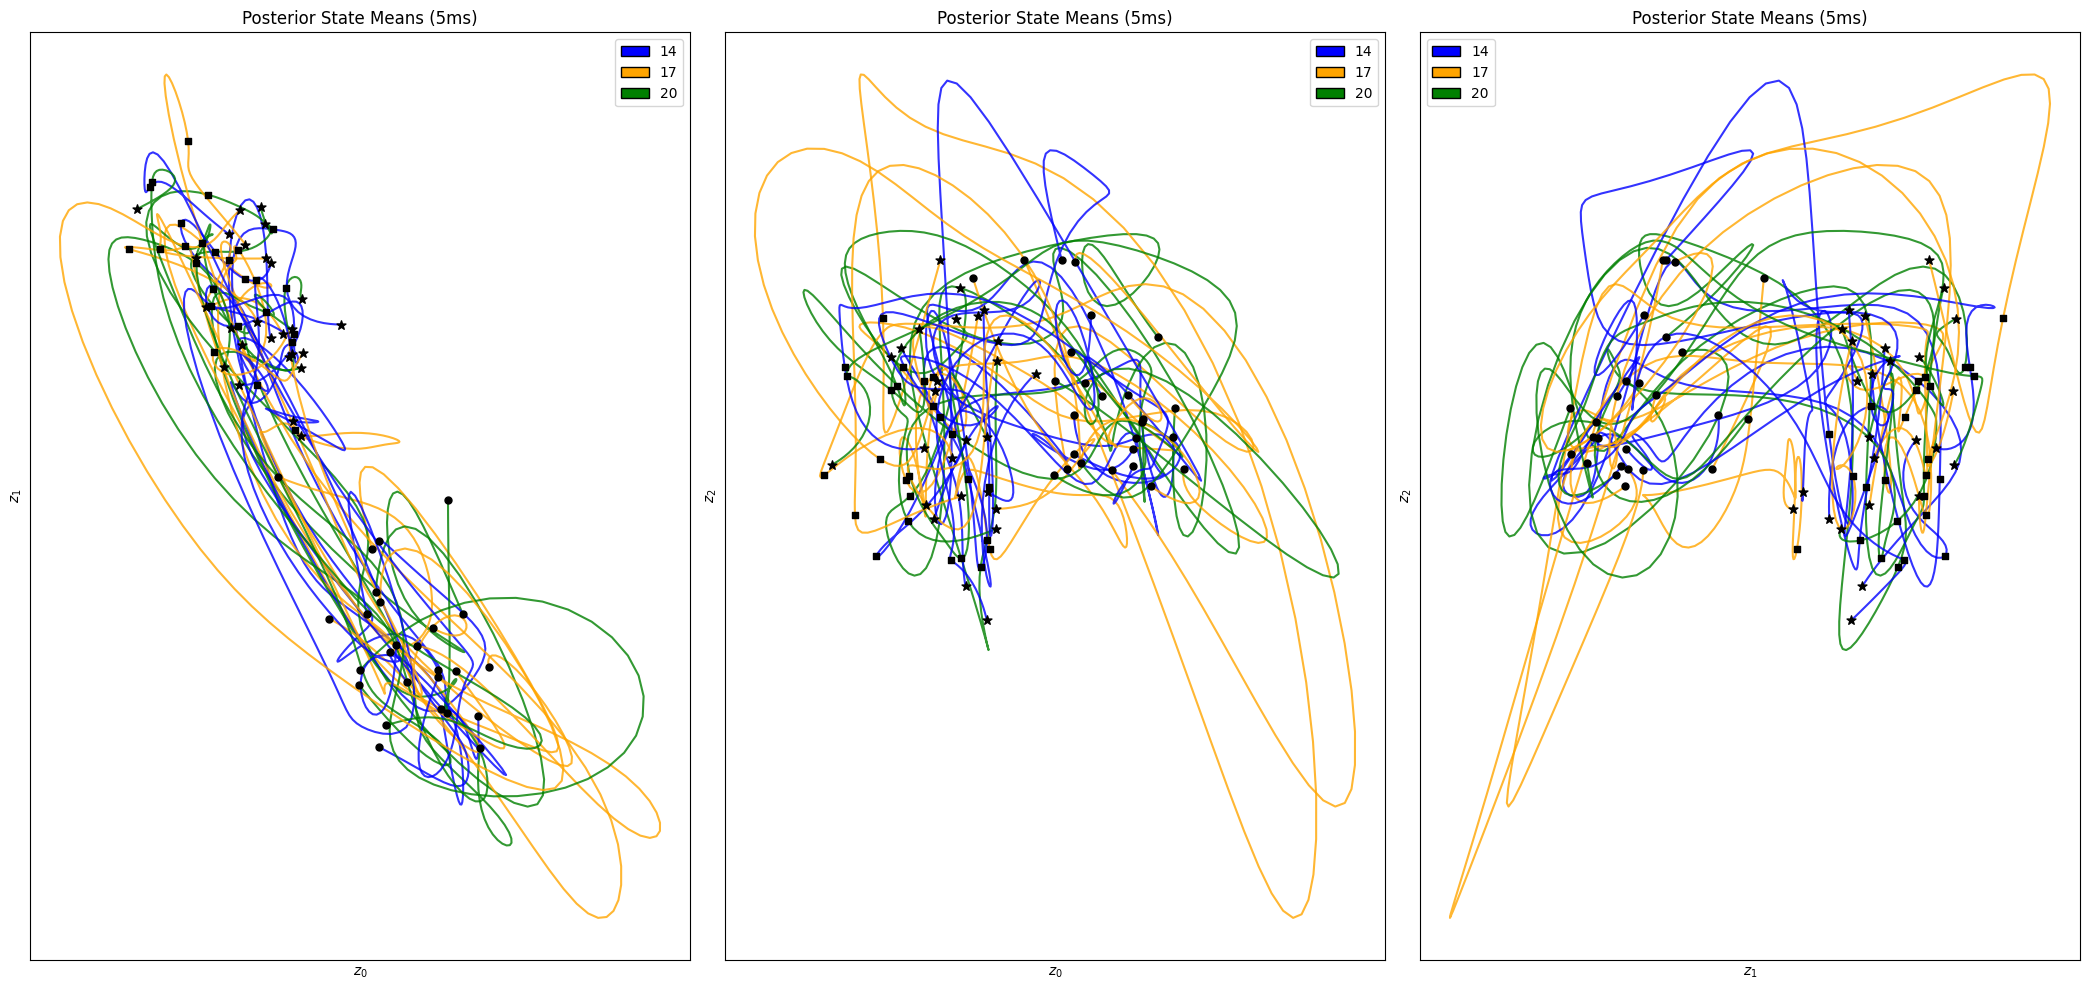

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(21, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, p in enumerate(state_means):

    cue = int(50 / bin_size)

    lift = int(data["lift_ms"][behavior_idxs[i], 0] / bin_size) + cue

    grab = int(data["grab_ms"][behavior_idxs[i], 0] / bin_size) + cue - 1
    
    p = gaussian_filter1d(p, 6, axis=0)

    axes[0].plot(p[:grab+1, 0], p[:grab+1, 1], c=colors[i], zorder=0, alpha=0.8)

    axes[0].scatter(p[0, 0], p[0, 1], s=25, marker='o', c="black", zorder=1, alpha=1)
    axes[0].scatter(p[lift, 0], p[lift, 1], s=25, marker='s', c="black", zorder=1, alpha=1, label="lift")
    axes[0].scatter(p[grab, 0], p[grab, 1], s=45, marker='*', c="black", zorder=1, alpha=1, label="grab")

    axes[1].plot(p[:grab+1, 0], p[:grab+1, 2], c=colors[i], zorder=0, alpha=0.8)

    axes[1].scatter(p[0, 0], p[0, 2], s=25, marker='o', c="black", zorder=1, alpha=1)
    axes[1].scatter(p[lift, 0], p[lift, 2], s=25, marker='s', c="black", zorder=1, alpha=1)
    axes[1].scatter(p[grab, 0], p[grab, 2], s=45, marker='*', c="black", zorder=1, alpha=1)

    axes[2].plot(p[:grab+1, 1], p[:grab+1, 2], c=colors[i], zorder=0, alpha=0.8)

    axes[2].scatter(p[0, 1], p[0, 2], s=25, marker='o', c="black", zorder=1, alpha=1)
    axes[2].scatter(p[lift, 1], p[lift, 2], s=25, marker='s', c="black", zorder=1, alpha=1)
    axes[2].scatter(p[grab, 1], p[grab, 2], s=45, marker='*', c="black", zorder=1, alpha=1)




for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Posterior State Means ({bin_size}ms)")
    ax.legend(handles=custom_patches)


# 0, 0 = x1 vs x2
axes[0].set_xlabel(f"$z_0$")
axes[0].set_ylabel(f"$z_1$")


# 0, 1 = x1 vs x3
axes[1].set_xlabel(f"$z_0$")
axes[1].set_ylabel(f"$z_2$")

# 0, 2 = x2 vs x3
axes[2].set_xlabel(f"$z_1$")
axes[2].set_ylabel(f"$z_2$")

plt.savefig(f"{path}state_means_all.png")

plt.tight_layout()

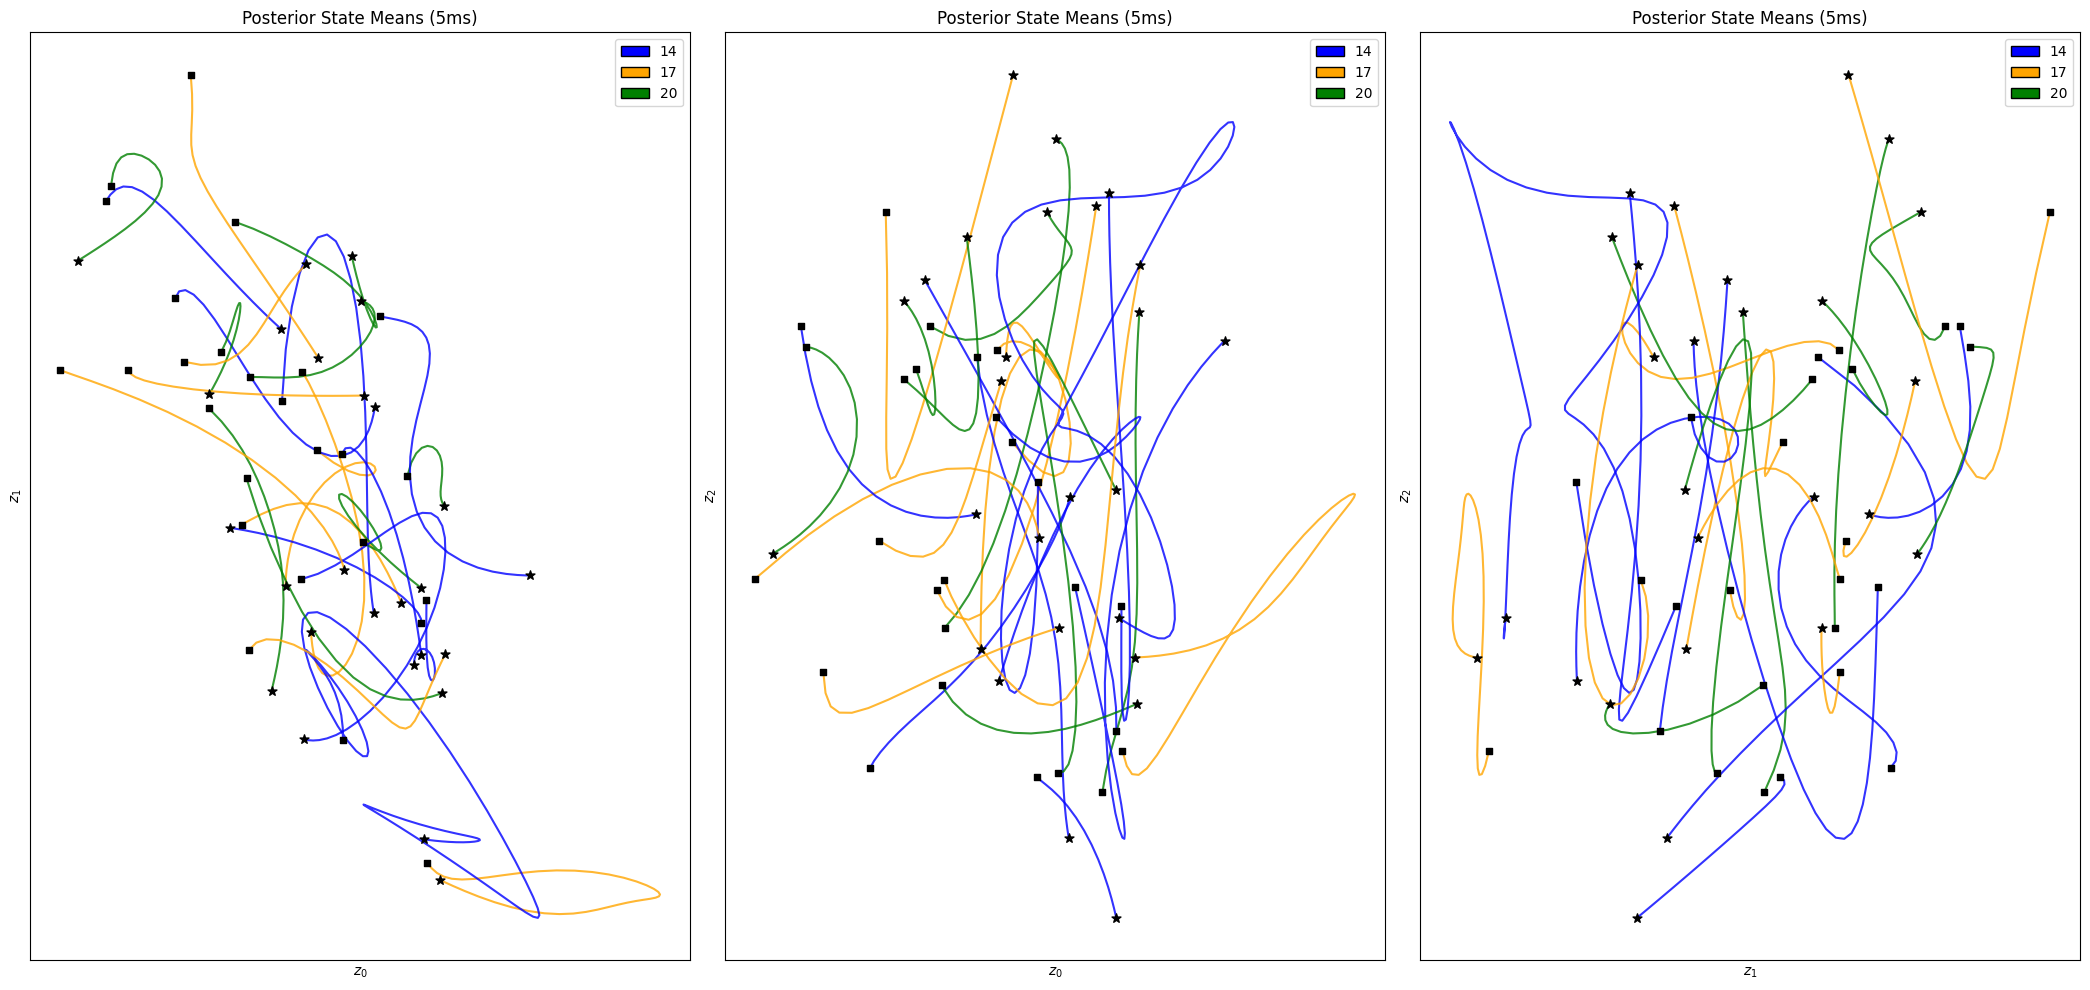

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(21, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, p in enumerate(state_means):

    cue = int(50 / bin_size)

    lift = int(data["lift_ms"][behavior_idxs[i], 0] / bin_size) + cue

    grab = int(data["grab_ms"][behavior_idxs[i], 0] / bin_size) + cue - 1

    p = gaussian_filter1d(p, 6, axis=0)

    axes[0].plot(p[lift:grab+1, 0], p[lift:grab+1, 1], c=colors[i], zorder=0, alpha=0.8)

    axes[0].scatter(p[lift, 0], p[lift, 1], s=25, marker='s', c="black", zorder=1, alpha=1)
    axes[0].scatter(p[grab, 0], p[grab, 1], s=45, marker='*', c="black", zorder=1, alpha=1)

    axes[1].plot(p[lift:grab+1, 0], p[lift:grab+1, 2], c=colors[i], zorder=0, alpha=0.8)

    axes[1].scatter(p[lift, 0], p[lift, 2], s=25, marker='s', c="black", zorder=1, alpha=1)
    axes[1].scatter(p[grab, 0], p[grab, 2], s=45, marker='*', c="black", zorder=1, alpha=1)

    axes[2].plot(p[lift:grab+1, 1], p[lift:grab+1, 2], c=colors[i], zorder=0, alpha=0.8)

    axes[2].scatter(p[lift, 1], p[lift, 2], s=25, marker='s', c="black", zorder=1, alpha=1)
    axes[2].scatter(p[grab, 1], p[grab, 2], s=45, marker='*', c="black", zorder=1, alpha=1)




for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Posterior State Means ({bin_size}ms)")
    ax.legend(handles=custom_patches)


# 0, 0 = x1 vs x2
axes[0].set_xlabel(f"$z_0$")
axes[0].set_ylabel(f"$z_1$")


# 0, 1 = x1 vs x3
axes[1].set_xlabel(f"$z_0$")
axes[1].set_ylabel(f"$z_2$")

# 0, 2 = x2 vs x3
axes[2].set_xlabel(f"$z_1$")
axes[2].set_ylabel(f"$z_2$")

plt.savefig(f"{path}state_means_behavior.png")

plt.tight_layout()

# Plot just points

In [117]:
a = Patch(facecolor="blue", edgecolor='black', label="cue")
b = Patch(facecolor="green", edgecolor='black', label="lift")
c = Patch(facecolor="red", edgecolor='black', label="grab")
custom_patches1 = [a, b, c]

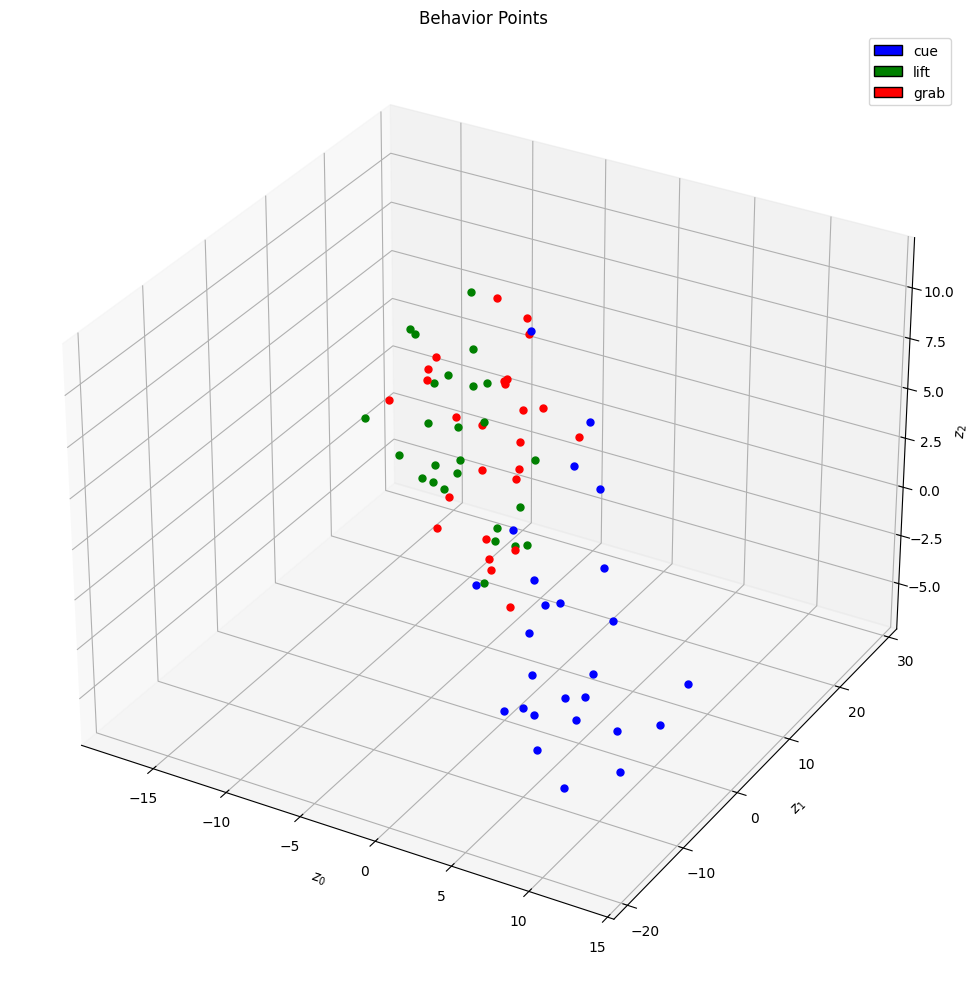

In [118]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={"projection": "3d"})

for i, p in enumerate(state_means):

    cue = int(50 / bin_size)

    lift = int(data["lift_ms"][behavior_idxs[i], 0] / bin_size) + cue

    grab = int(data["grab_ms"][behavior_idxs[i], 0] / bin_size) + cue - 1

    p = gaussian_filter1d(p, 6, axis=0)

    axes.scatter(p[cue, 0], p[cue, 1], p[cue, 2], s=25, marker='o', c="blue", zorder=1, alpha=1)
    axes.scatter(p[lift, 0], p[lift, 1], p[lift, 2], s=25, marker='o', c="green", zorder=1, alpha=1)
    axes.scatter(p[grab, 0], p[grab, 1], p[grab, 2], s=25, marker='o', c="red", zorder=1, alpha=1)

axes.set_xlabel("$z_0$")
axes.set_ylabel("$z_1$")
axes.set_zlabel("$z_2$")

plt.title("Behavior Points")

plt.legend(handles=custom_patches1)

plt.tight_layout()

plt.savefig(f"{path}behavior_points.png")
plt.show()

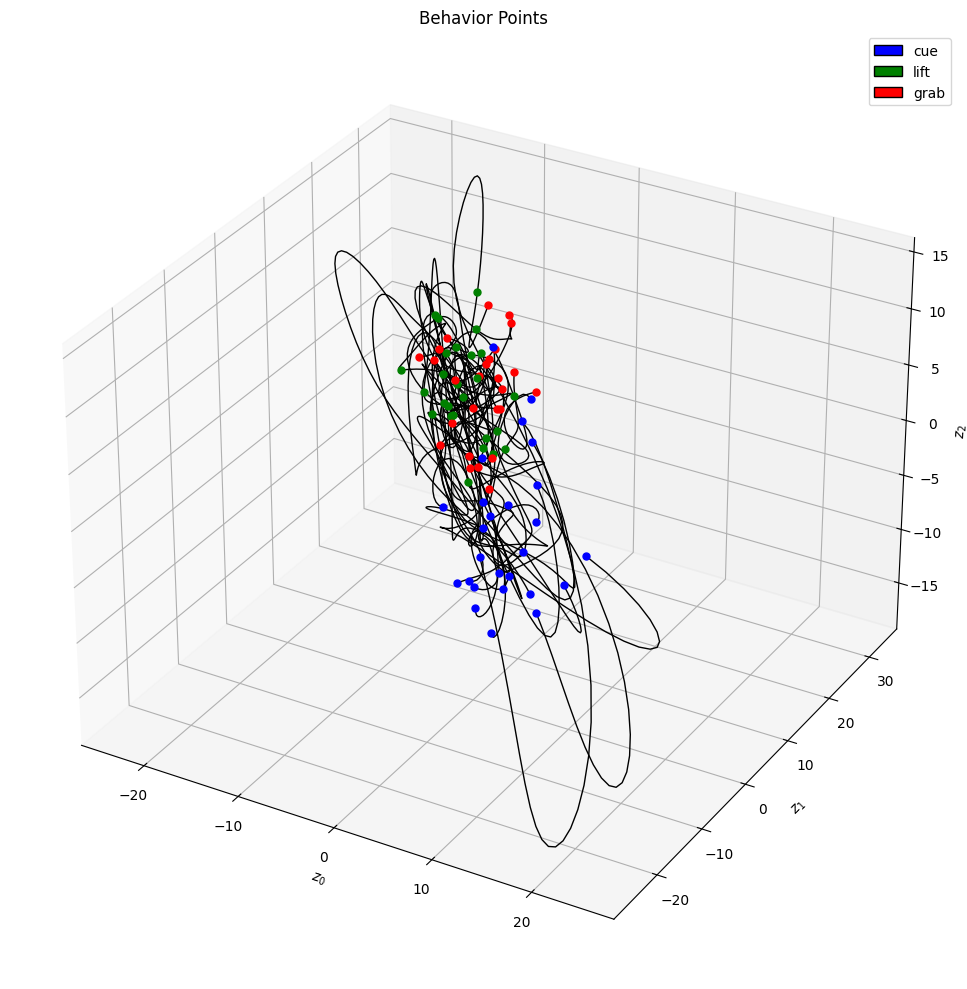

In [119]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={"projection": "3d"})

for i, p in enumerate(state_means):

    cue = int(50 / bin_size)

    lift = int(data["lift_ms"][behavior_idxs[i], 0] / bin_size) + cue

    grab = int(data["grab_ms"][behavior_idxs[i], 0] / bin_size) + cue - 1

    p = gaussian_filter1d(p, 6, axis=0)

    axes.plot(p[cue:, 0], p[cue:, 1], p[cue:, 2], c="black", lw=1)

    axes.scatter(p[cue, 0], p[cue, 1], p[cue, 2], s=25, marker='o', c="blue", zorder=1, alpha=1)
    axes.scatter(p[lift, 0], p[lift, 1], p[lift, 2], s=25, marker='o', c="green", zorder=1, alpha=1)
    axes.scatter(p[grab, 0], p[grab, 1], p[grab, 2], s=25, marker='o', c="red", zorder=1, alpha=1)

axes.set_xlabel("$z_0$")
axes.set_ylabel("$z_1$")
axes.set_zlabel("$z_2$")

plt.title("Behavior Points")

plt.legend(handles=custom_patches1)

plt.tight_layout()

plt.savefig(f"{path}behavior_points2.png")
plt.show()

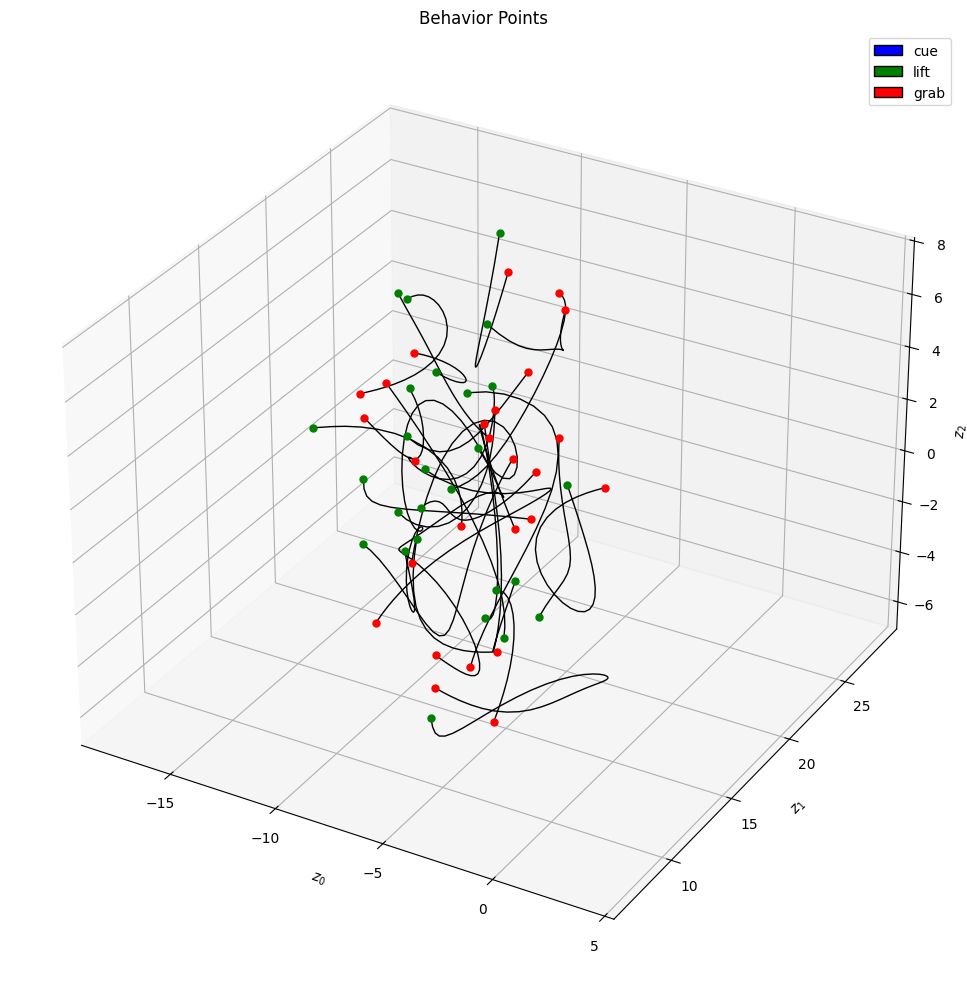

In [120]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={"projection": "3d"})

for i, p in enumerate(state_means):

    cue = int(50 / bin_size)

    lift = int(data["lift_ms"][behavior_idxs[i], 0] / bin_size) + cue

    grab = int(data["grab_ms"][behavior_idxs[i], 0] / bin_size) + cue - 1

    p = gaussian_filter1d(p, 6, axis=0)

    axes.plot(p[lift:, 0], p[lift:, 1], p[lift:, 2], c="black", lw=1)

   # axes.scatter(p[cue, 0], p[cue, 1], p[cue, 2], s=25, marker='o', c="blue", zorder=1, alpha=1)
    axes.scatter(p[lift, 0], p[lift, 1], p[lift, 2], s=25, marker='o', c="green", zorder=1, alpha=1)
    axes.scatter(p[grab, 0], p[grab, 1], p[grab, 2], s=25, marker='o', c="red", zorder=1, alpha=1)

axes.set_xlabel("$z_0$")
axes.set_ylabel("$z_1$")
axes.set_zlabel("$z_2$")

plt.title("Behavior Points")

plt.legend(handles=custom_patches1)

plt.tight_layout()

plt.savefig(f"{path}behavior_points3.png")
plt.show()

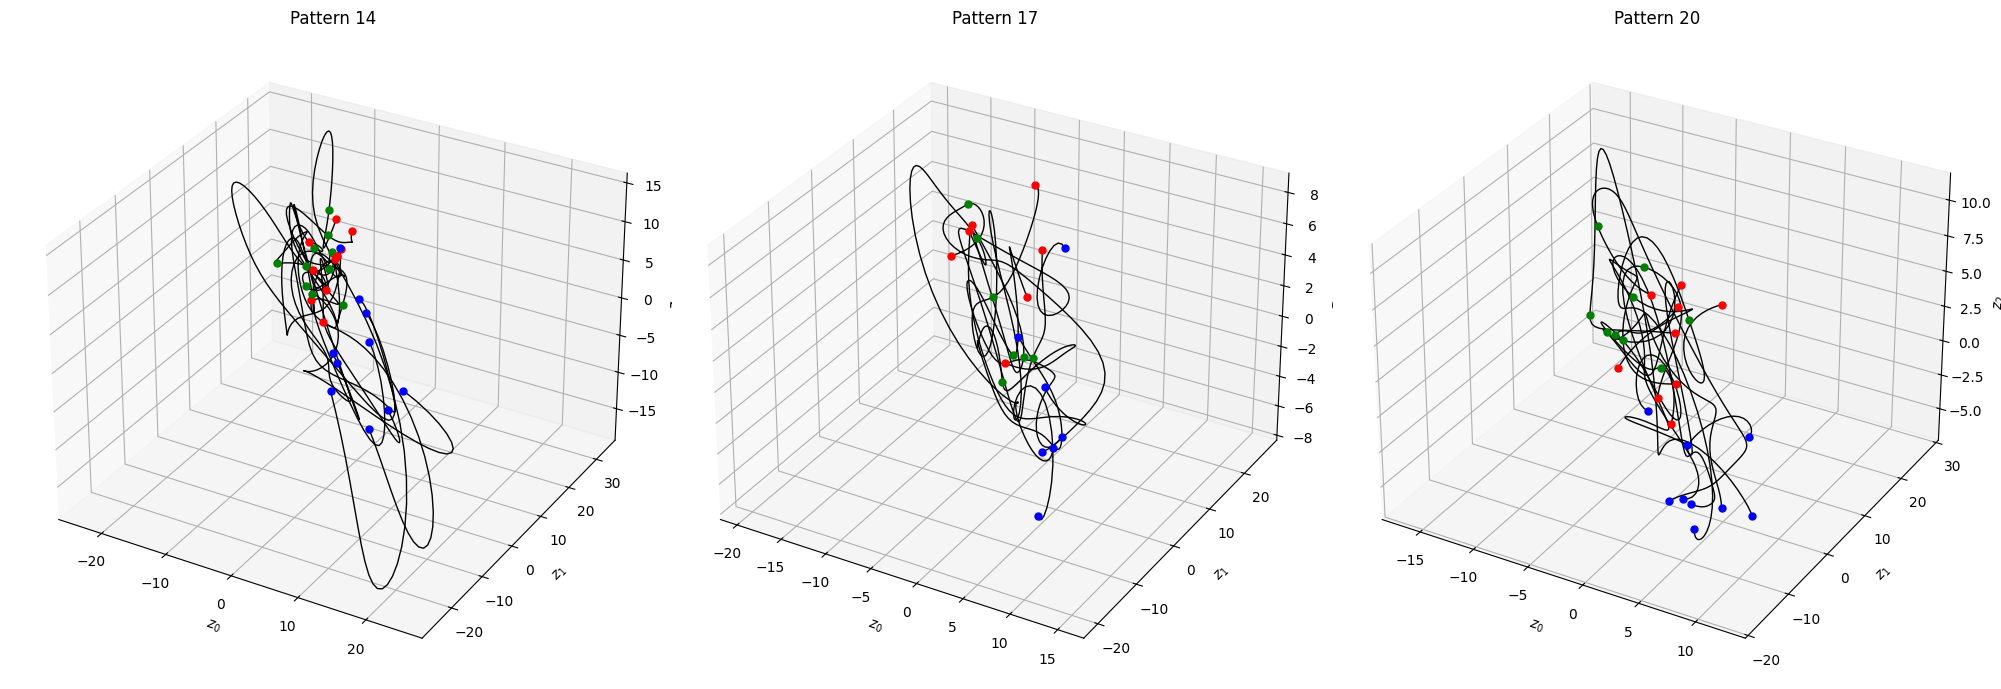

In [131]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10), subplot_kw={"projection": "3d"})

axes = axes.flatten()

for i, p in enumerate(state_means):

    cue = int(50 / bin_size)

    lift = int(data["lift_ms"][behavior_idxs[i], 0] / bin_size) + cue

    grab = int(data["grab_ms"][behavior_idxs[i], 0] / bin_size) + cue - 1

    p_id = int(data["pattern_id"][0][behavior_idxs[i]]) 

    p = gaussian_filter1d(p, 6, axis=0)

    if p_id == 14:
        ax = axes[0] 
        ax.set_title("Pattern 14")
    elif p_id == 17: 
        ax = axes[1] 
        ax.set_title("Pattern 17")
    else:
        ax = axes[2]
        ax.set_title("Pattern 20")
    ax.plot(p[cue:, 0], p[cue:, 1], p[cue:, 2], c="black", lw=1)

    ax.scatter(p[cue, 0], p[cue, 1], p[cue, 2], s=25, marker='o', c="blue", zorder=1, alpha=1)
    ax.scatter(p[lift, 0], p[lift, 1], p[lift, 2], s=25, marker='o', c="green", zorder=1, alpha=1)
    ax.scatter(p[grab, 0], p[grab, 1], p[grab, 2], s=25, marker='o', c="red", zorder=1, alpha=1)
    
for ax in axes:
    ax.set_xlabel("$z_0$")
    ax.set_ylabel("$z_1$")
    ax.set_zlabel("$z_2$")

# plt.title("Behavior Points")

#plt.legend(handles=custom_patches)

plt.tight_layout()

plt.savefig(f"{path}behavior_points4.png")
plt.show()

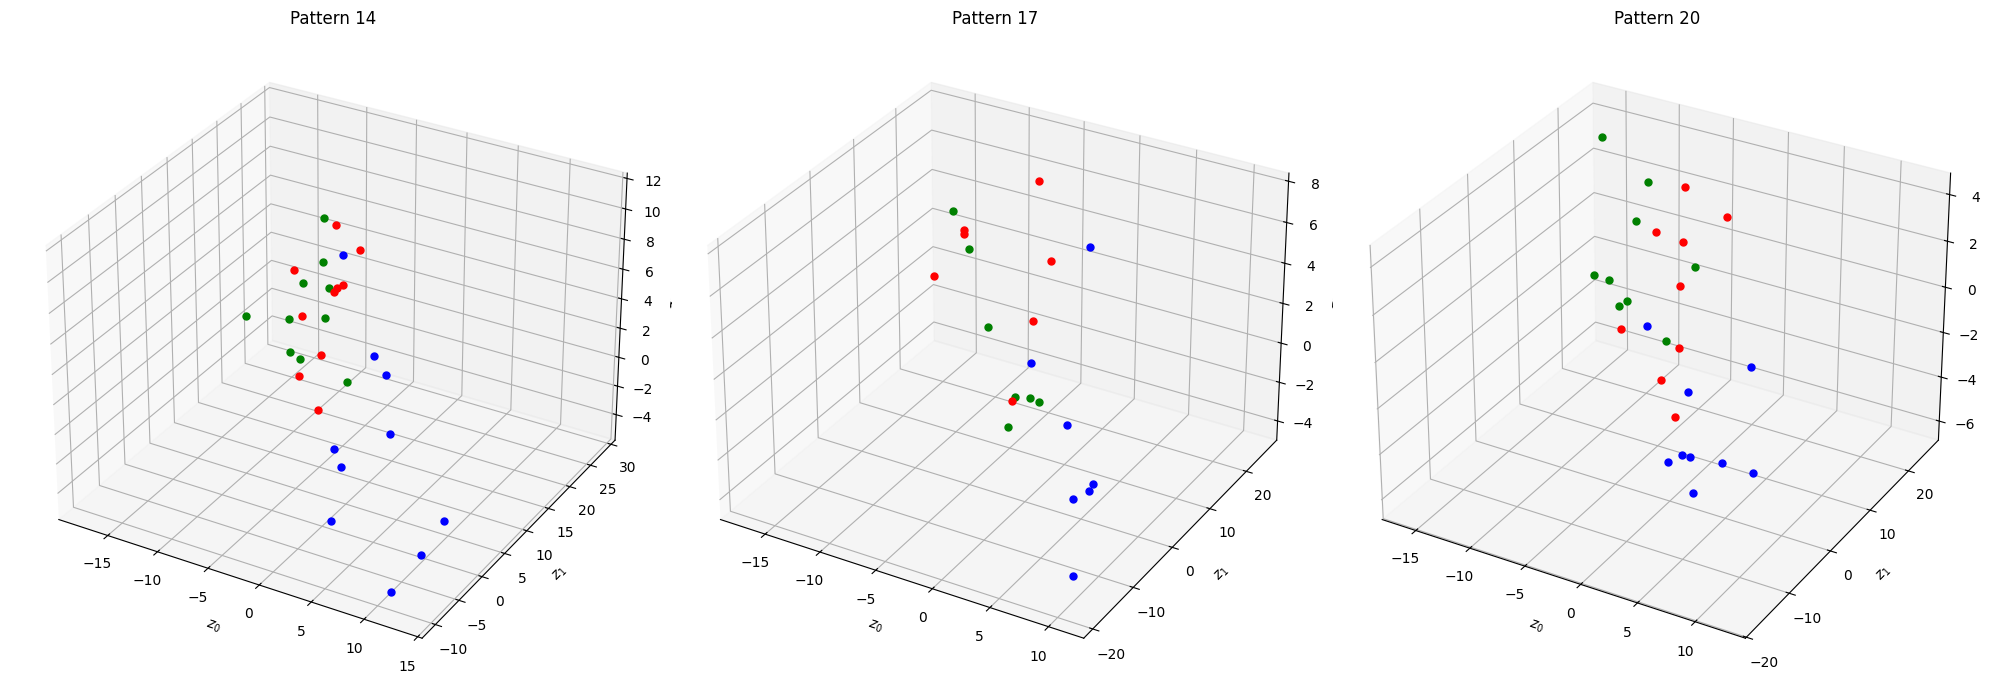

In [132]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10), subplot_kw={"projection": "3d"})

axes = axes.flatten()

for i, p in enumerate(state_means):

    cue = int(50 / bin_size)

    lift = int(data["lift_ms"][behavior_idxs[i], 0] / bin_size) + cue

    grab = int(data["grab_ms"][behavior_idxs[i], 0] / bin_size) + cue - 1

    p_id = int(data["pattern_id"][0][behavior_idxs[i]]) 

    p = gaussian_filter1d(p, 6, axis=0)

    if p_id == 14:
        ax = axes[0] 
        ax.set_title("Pattern 14")
    elif p_id == 17: 
        ax = axes[1] 
        ax.set_title("Pattern 17")
    else:
        ax = axes[2]
        ax.set_title("Pattern 20")
  #  ax.plot(p[cue:, 0], p[cue:, 1], p[cue:, 2], c="black", lw=1)

    ax.scatter(p[cue, 0], p[cue, 1], p[cue, 2], s=25, marker='o', c="blue", zorder=1, alpha=1)
    ax.scatter(p[lift, 0], p[lift, 1], p[lift, 2], s=25, marker='o', c="green", zorder=1, alpha=1)
    ax.scatter(p[grab, 0], p[grab, 1], p[grab, 2], s=25, marker='o', c="red", zorder=1, alpha=1)
    
for ax in axes:
    ax.set_xlabel("$z_0$")
    ax.set_ylabel("$z_1$")
    ax.set_zlabel("$z_2$")

# plt.title("Behavior Points")

#plt.legend(handles=custom_patches)

plt.tight_layout()

plt.savefig(f"{path}behavior_points5.png")
plt.show()

# Plot discrete states

In [61]:
discrete_states = list()

for i in range(len(state_means)):
    z_s = plds.most_likely_states(state_means[i], model_data[i], inputs[i])
    discrete_states.append(z_s)

In [62]:
max_len = max(len(arr) for arr in discrete_states)

# 2. Initialize the 2D array with NaNs
# The number of rows is the number of 1D arrays
# The number of columns is the max_len
s = np.full((len(discrete_states), max_len), np.nan)

# 3. Populate the 2D array
for i, arr in enumerate(discrete_states):
    s[i, :len(arr)] = arr

In [63]:
# plot each row 
s.shape

(26, 134)

In [64]:
s[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan])

In [61]:
import matplotlib.colors as mcolors

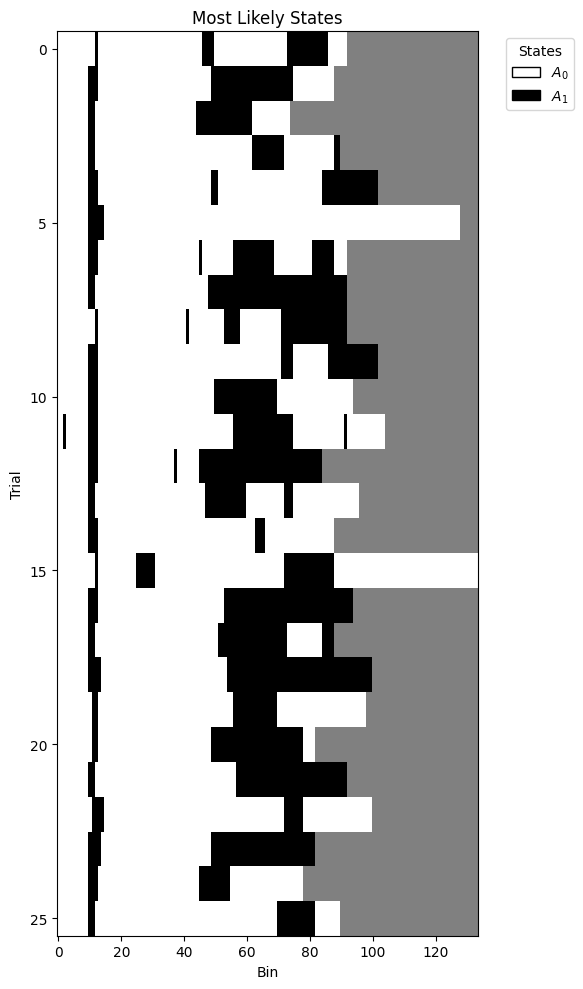

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(6, 10))

masked_data = np.ma.array(s, mask=np.isnan(s))

cmap = plt.cm.binary  # Or any other colormap
cmap.set_bad('gray')  # Set NaN values to be red
    

cax = ax.matshow(masked_data, cmap=cmap, aspect="auto")

plt.tight_layout()

ax.set_xlabel("Bin")
ax.set_ylabel("Trial")

ax.xaxis.set_ticks_position('bottom')

# for lt in lift_times:
#     lt = int(lt / bin_size) + 10
#     ax.axvline(lt)


ax.set_title("Most Likely States")

cs = {0: "white", 1: "black" }
labels = {0: '$A_0$', 1: '$A_1$'}

patches = [Patch(facecolor=cs[val], label=labels[val], edgecolor="black")
               for val in cs.keys()]

plt.legend(handles=patches, title="States", bbox_to_anchor=(1.05, 1), loc='upper left')

#fig.colorbar(cax)

plt.tight_layout()

plt.savefig(f"{path}states.png")

plt.show()

In [66]:
s[0].shape

(134,)

# Plotting B

In [67]:
Bs = plds.dynamics.params[2]
Bs.shape

(2, 3, 144)

In [68]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import CenteredNorm

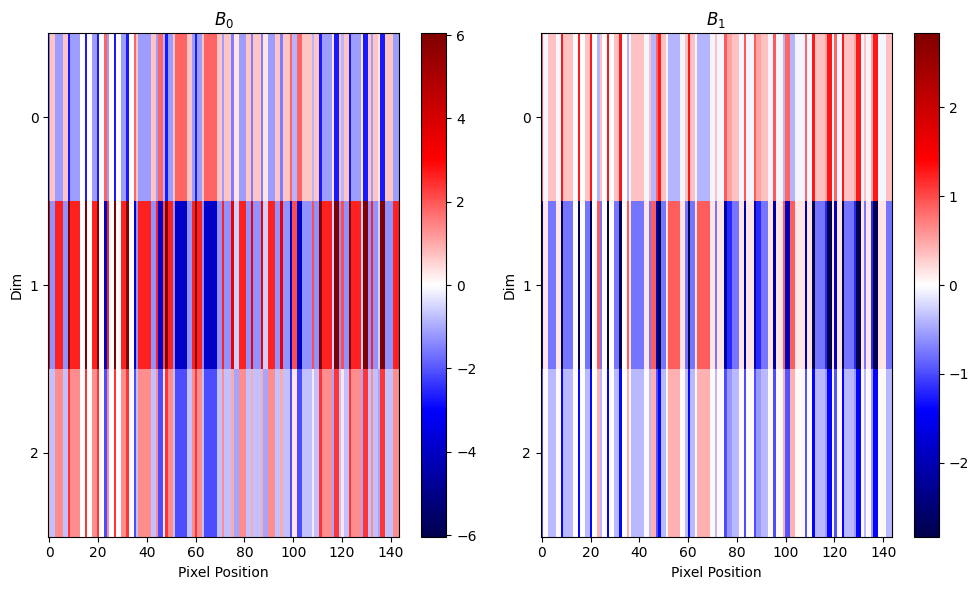

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, ax in enumerate(axes):
    im = ax.matshow(Bs[i], cmap="seismic", aspect='auto', norm=CenteredNorm(vcenter=0))

    ax.set_title(f"$B_{i}$")
    ax.set_ylabel("Dim")
    ax.set_xlabel("Pixel Position")

    ax.xaxis.tick_bottom()

    fig.colorbar(im, ax=ax)

plt.tight_layout()

plt.savefig(f"{path}B.png")

plt.show()

In [70]:
Bs.shape

(2, 3, 144)

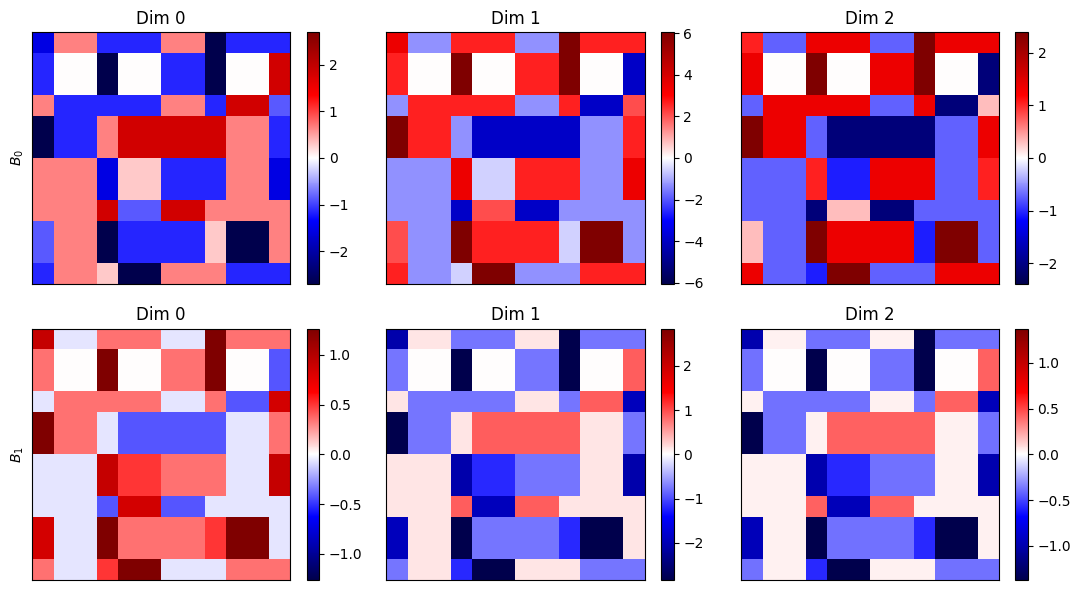

In [71]:
fig, axes = plt.subplots(2, 3, figsize=(11, 6))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i in range(3):
    ax = axes[i]
    im = ax.matshow(Bs[0][i].reshape(12, 12), cmap='seismic', aspect='auto', norm=CenteredNorm(vcenter=0))
    ax.set_title(f'Dim {i}')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    fig.colorbar(im, ax=ax)


for i in range(3):
    ax = axes[i+3]
    im = ax.matshow(Bs[1][i].reshape(12, 12), cmap='seismic', aspect='auto',norm=CenteredNorm(vcenter=0))
    ax.set_title(f'Dim {i}')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    fig.colorbar(im, ax=ax)


axes[0].set_ylabel("$B_0$")
axes[3].set_ylabel("$B_1$")

plt.tight_layout()

plt.savefig(f"{path}B2.png")
plt.show()

In [72]:
p_ids

array([14., 17., 20.])

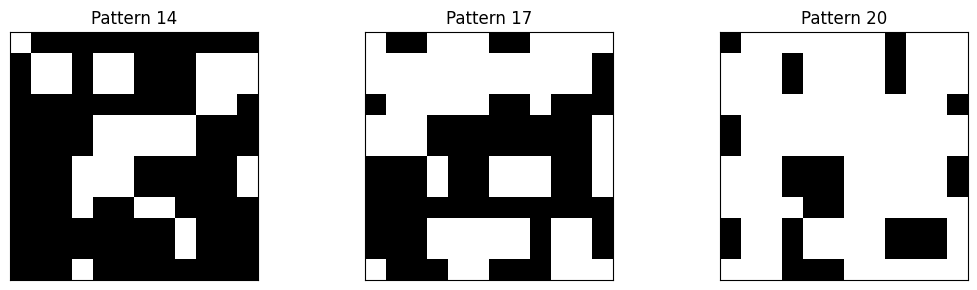

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(11, 3))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i in range(3):
    ax = axes[i] 
    ax.matshow(all_patterns[int(p_ids[i] - 3)], cmap="binary")
    ax.set_title(f"Pattern {int(p_ids[i])}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

plt.savefig(f"{path}/p_id.png")

plt.show()

In [75]:
# Build predictors and responses
X_list = []
Y_list = []

for i in range(len(state_means)):
    z_trial = (1-discrete_states[i]) * state_means[i].T 
    z_trial = z_trial.T# (T, d)
    
    # compute residual: z_t - A z_{t-1} - b
    z_t = z_trial[1:]             # (T-1, d)
    z_tm1 = z_trial[:-1]
    u = (1-discrete_states[i]) * inputs[i].T
    u_tm1 = u.T[:-1]                  # assume same u across trials
    
    residual = z_t - (z_tm1 @ As[0].T + b)  # (T-1, d)
    
    X_list.append(u_tm1)     # predictors
    Y_list.append(residual)  # targets

X = np.vstack(X_list)  # shape (trials*(T-1), input_dim)
Y = np.vstack(Y_list)  # shape (trials*(T-1), d)

In [76]:
X.shape

(2430, 144)

In [77]:
Y.shape

(2430, 3)

In [78]:
from sklearn.linear_model import Lasso, LassoCV

In [79]:
from sklearn.linear_model import MultiTaskLasso

In [80]:
B_sparse0 = np.zeros((3, 144))

#for i in range(3):
    # model = LassoCV(cv=5, alphas=np.linspace(0.001, 0.1, 20), fit_intercept=False)  # cross-validated alpha
    # #model = Lasso(alpha=0.001, fit_intercept=False)
    # model.fit(X, Y[:, i])
    # B_sparse0[i] = model.coef_

model = MultiTaskLasso(alpha=0.0001, fit_intercept=False)  # adjust alpha for more/less sparsity
model.fit(X, Y)

# Coefficient matrix
B_sparse0 = model.coef_   # shape (3, 144)
   # print(W.shape)  
  #   lasso = Lasso(alpha=alpha, fit_intercept=True)
  # #  lasso.fit(U_all, Z_all[:, i])
  #   lasso.fit(X, Y[:, i])
  #   B_sparse[i, :] = lasso.coef_

Text(0.5, 1.0, '$B$')

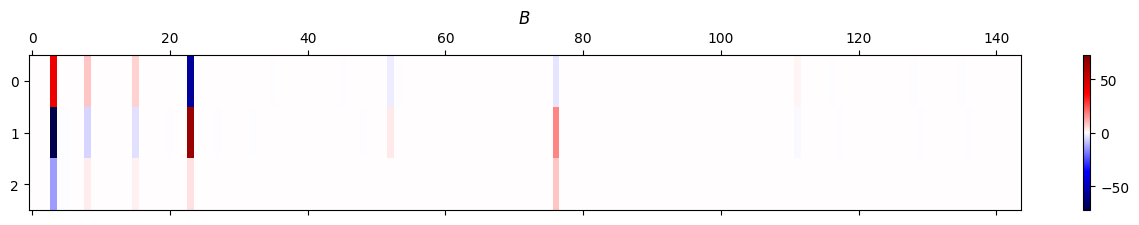

In [81]:
im = plt.matshow(B_sparse0, cmap='seismic', aspect='auto', norm=CenteredNorm(vcenter=0))
plt.colorbar(im)

plt.title("$B$")

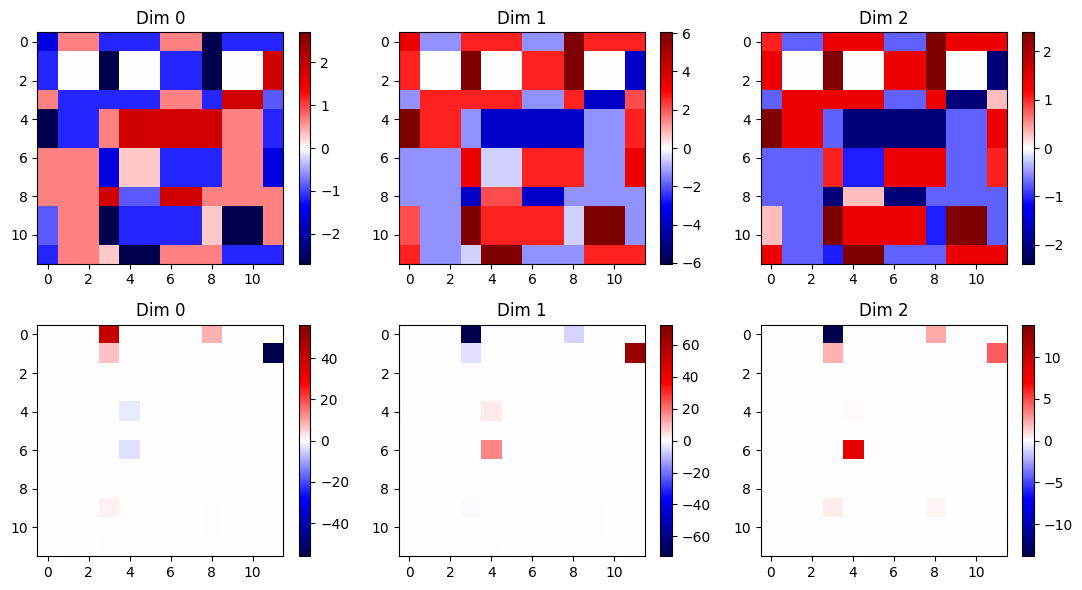

In [82]:
fig, axes = plt.subplots(2, 3, figsize=(11, 6))

# Flatten axes array for easy iteration
axes = axes.flatten()


for i in range(3):
    ax = axes[i]
    im = ax.matshow(Bs[0][i].reshape(12, 12), cmap='seismic', aspect='auto', norm=CenteredNorm(vcenter=0))
    ax.set_title(f'Dim {i}')
    ax.xaxis.tick_bottom()
    fig.colorbar(im, ax=ax)

for i in range(3):
    ax = axes[i+3]
    im = ax.matshow(B_sparse0[i].reshape(12, 12), cmap='seismic', aspect='auto', norm=CenteredNorm(vcenter=0))
    ax.xaxis.tick_bottom()
    fig.colorbar(im, ax=ax)
    ax.set_title(f'Dim {i}')
    ax.xaxis.tick_bottom()

plt.tight_layout()

plt.savefig(f"{path}B_reduced_dim0.png")
plt.show()

# Lasso regression for B_1

In [83]:
state_means[i].T.shape

(3, 74)

In [84]:
# Build predictors and responses
X_list = []
Y_list = []

for i in range(len(state_means)):
    z_trial = discrete_states[i] * state_means[i].T 
    z_trial = z_trial.T# (T, d)
    
    # compute residual: z_t - A z_{t-1} - b
    z_t = z_trial[1:]             # (T-1, d)
    z_tm1 = z_trial[:-1] 
    u = discrete_states[i] * inputs[i].T
    u_tm1 = u.T[:-1]                  # assume same u across trials
    
    residual = z_t - (z_tm1 @  As[1].T + b)  # (T-1, d)
    
    X_list.append(u_tm1)     # predictors
    Y_list.append(residual)  # targets

X = np.vstack(X_list)  # shape (trials*(T-1), input_dim)
Y = np.vstack(Y_list)  # shape (trials*(T-1), d)

In [85]:
from sklearn.linear_model import MultiTaskLasso

In [86]:
B_sparse1 = np.zeros((3, 144))


# for i in range(3):
#     model = LassoCV(cv=5, alphas=np.linspace(0.001, 0.1, 20), fit_intercept=False)
#     #model = Lasso(alpha=0.001, fit_intercept=False)# cross-validated alpha
#     model.fit(X, Y[:, i])
#     B_sparse1[i] = model.coef_
model2 = MultiTaskLasso(alpha=0.0001, fit_intercept=False)  # adjust alpha for more/less sparsity
model2.fit(X, Y)

# Coefficient matrix
B_sparse1 = model2.coef_  

Text(0.5, 1.0, '$B$')

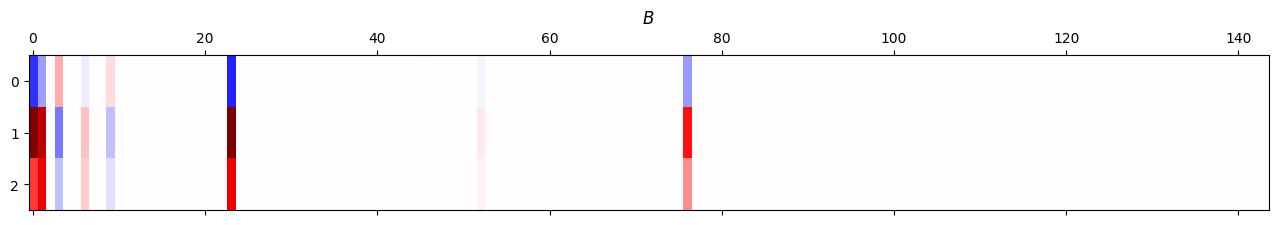

In [87]:
plt.matshow(B_sparse1, cmap='seismic', aspect='auto', norm=CenteredNorm())

plt.title("$B$")

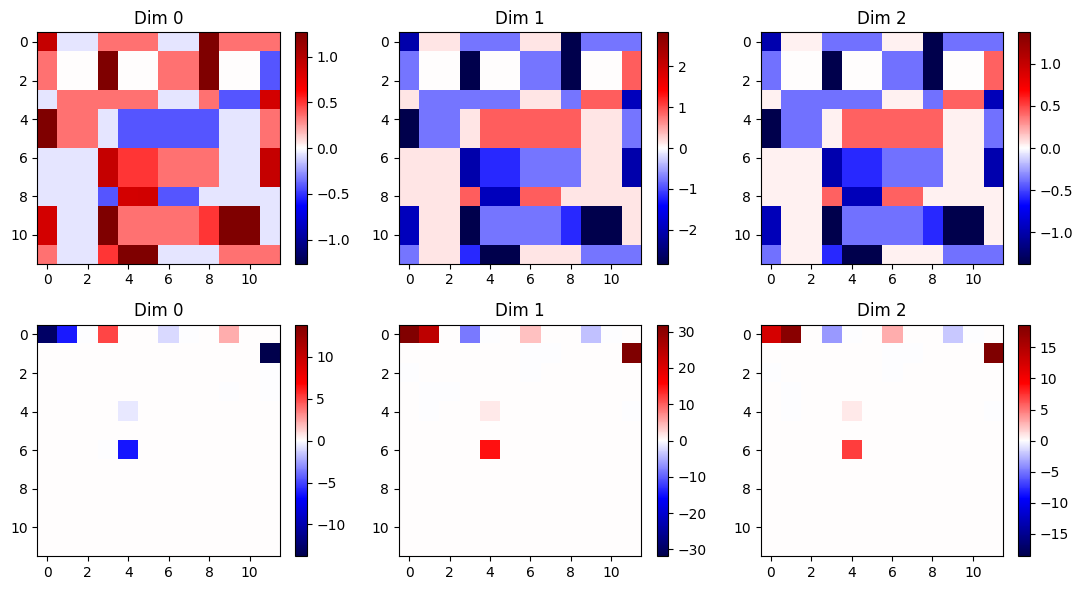

In [88]:
fig, axes = plt.subplots(2, 3, figsize=(11, 6))

# Flatten axes array for easy iteration
axes = axes.flatten()


for i in range(3):
    ax = axes[i]
    im = ax.matshow(Bs[1][i].reshape(12, 12), cmap='seismic', aspect='auto', norm=CenteredNorm())
    # Create a Rectangle patch with the same dimensions as the image
  #  rect = patches.Rectangle((0, 0), data[i].shape[1] - 1, data[i].shape[0] - 1, linewidth=1, edgecolor='black', facecolor='none')
    
    # Add the patch to the axes
 #   ax.add_patch(rect)
    ax.set_title(f'Dim {i}')
    ax.xaxis.tick_bottom()
    fig.colorbar(im, ax=ax)
    # ax.get_xaxis().set_ticks([])
    # ax.get_yaxis().set_ticks([])

for i in range(3):
    ax = axes[i+3]
    im = ax.matshow(B_sparse1[i].reshape(12, 12), cmap='seismic', aspect='auto', norm=CenteredNorm())
    ax.xaxis.tick_bottom()
    fig.colorbar(im, ax=ax)
    # Create a Rectangle patch with the same dimensions as the image
  #  rect = patches.Rectangle((0, 0), data[i].shape[1] - 1, data[i].shape[0] - 1, linewidth=1, edgecolor='black', facecolor='none')
    
    # Add the patch to the axes
 #   ax.add_patch(rect)
    ax.set_title(f'Dim {i}')
    # ax.get_xaxis().set_ticks([])
    # ax.get_yaxis().set_ticks([])
    ax.xaxis.tick_bottom()
#    ax.axis('off')  # Turn off axis

plt.tight_layout()

#plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/plds_stim/pixel/lasso_regression_alpha_{alpha}.png")
plt.savefig(f"{path}B_reduced_dim1.png")
plt.show()

# Plot the Rs

Where are different phases active in space? 

In [89]:
Rs = plds.transitions.Rs
Rs.shape

(2, 3)

In [90]:
# get x and y bounds (pick dim 1 and dim 2)

In [91]:
state_means[0].shape

(92, 3)

In [92]:
x_min = int(sum([min(s[:, 0]) for s in state_means]) / len(state_means))
x_max = int(sum([max(s[:, 0]) for s in state_means]) / len(state_means))
x_min, x_max

(-50, 40)

In [93]:
y_min = int(sum([min(s[:, 1]) for s in state_means]) / len(state_means))
y_max = int(sum([max(s[:, 1]) for s in state_means]) / len(state_means))
y_min, y_max

(-54, 76)

In [94]:
z_min = int(sum([min(s[:, 2]) for s in state_means]) / len(state_means))
z_max = int(sum([max(s[:, 2]) for s in state_means]) / len(state_means))
z_min, z_max

(-33, 51)

In [95]:
X = np.linspace(x_min, x_max, 50)
Y = np.linspace(y_min, y_max, 50) 
Z = np.linspace(z_min, z_max, 50)

XY = np.vstack([X, Y]).T
XZ = np.vstack([X, Z]).T
YZ = np.vstack([Y, Z]).T
XY.shape, XZ.shape, YZ.shape

((50, 2), (50, 2), (50, 2))

In [96]:
import scipy

In [97]:
a = scipy.special.softmax(XY.dot(Rs[:, :2].T), axis=1)
a.shape

(50, 2)

In [98]:
np.argmax(a, axis=1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [99]:
a.shape

(50, 2)

In [100]:
from matplotlib.colors import LinearSegmentedColormap

In [101]:
def gradient_cmap(gcolors, nsteps=256, bounds=None):
    """
    Make a colormap that interpolates between a set of colors
    """
    ncolors = len(gcolors)
    if bounds is None:
        bounds = np.linspace(0, 1, ncolors)

    reds = []
    greens = []
    blues = []
    alphas = []
    for b, c in zip(bounds, gcolors):
        reds.append((b, c[0], c[0]))
        greens.append((b, c[1], c[1]))
        blues.append((b, c[2], c[2]))
        alphas.append((b, c[3], c[3]) if len(c) == 4 else (b, 1., 1.))

    cdict = {'red': tuple(reds),
             'green': tuple(greens),
             'blue': tuple(blues),
             'alpha': tuple(alphas)}

    cmap = LinearSegmentedColormap('grad_colormap', cdict, nsteps)
    return cmap

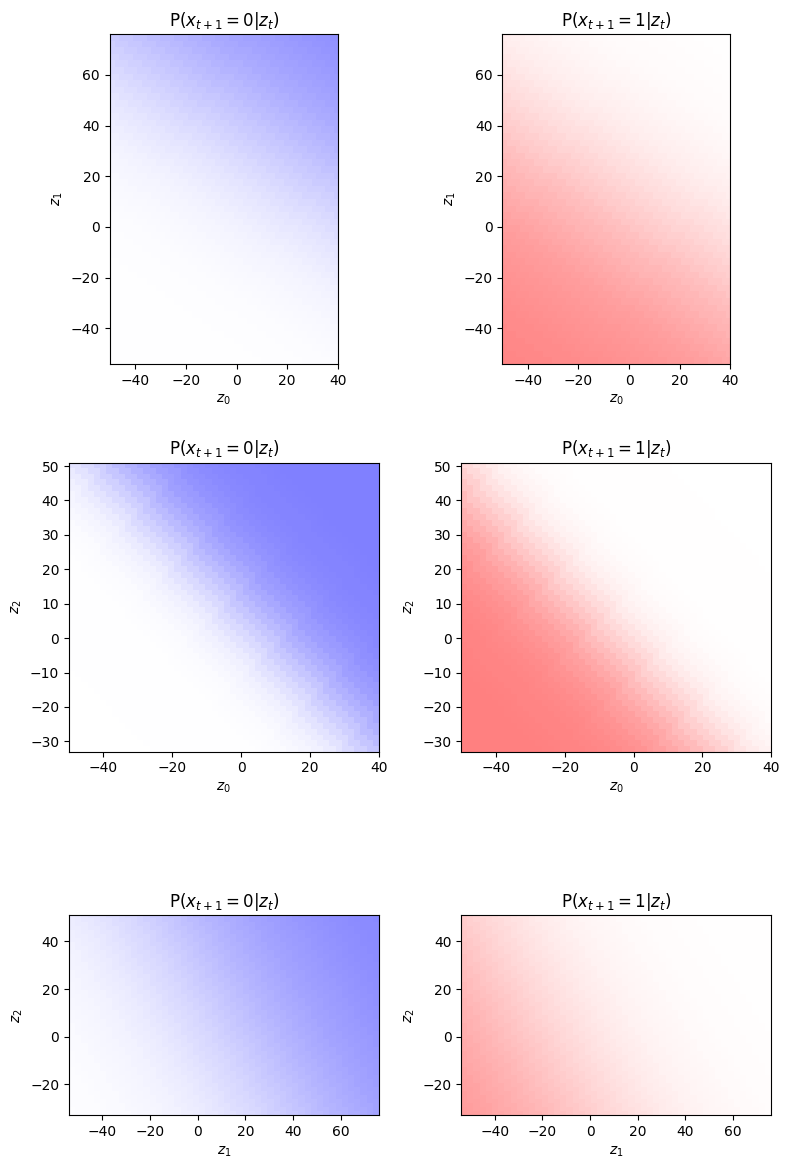

In [102]:
K = 2

c = [np.array([0, 0, 1]), np.array([1, 0, 0])]

fig, axes = plt.subplots(3, K, figsize=(4*K, 4*3))

axes = axes.flatten()

for k in range(K):
    state_probs = scipy.special.softmax(XY.dot(Rs[:, :2].T), axis=1)
    XX, YY = np.meshgrid(X, Y)
    # Interpolate probabilities for this state
    Q = scipy.interpolate.griddata(points=XY, values=state_probs[:, k],
                 xi=(XX, YY), method='nearest')

    start = np.array([1., 1., 1., 0.])
    end = np.concatenate((c[k], [0.5]))
    cmap = gradient_cmap([start, end])

    ax = axes[k]
    im = ax.imshow(Q, extent=(X.min(), X.max(), Y.min(), Y.max()),
                   origin='lower', cmap=cmap, vmin=0, vmax=1,
                   alpha=1)

    ax.set_xlabel("$z_0$")
    ax.set_ylabel("$z_1$")

axes[0].set_title("P$(x_{t+1}=0 | z_t)$")
axes[1].set_title("P$(x_{t+1}=1 | z_t)$")

# z1 vs z2

for k in range(K):
    state_probs = scipy.special.softmax(XZ.dot(Rs[:, [0, 2]].T), axis=1)
    XX, YY = np.meshgrid(X, Z)
    # Interpolate probabilities for this state
    Q = scipy.interpolate.griddata(points=XZ, values=state_probs[:, k],
                 xi=(XX, YY), method='nearest')

    start = np.array([1., 1., 1., 0.])
    end = np.concatenate((c[k], [0.5]))
    cmap = gradient_cmap([start, end])

    ax = axes[k+2]
    im = ax.imshow(Q, extent=(X.min(), X.max(), Z.min(), Z.max()),
                   origin='lower', cmap=cmap, vmin=0, vmax=1,
                   alpha=1)

    ax.set_xlabel("$z_0$")
    ax.set_ylabel("$z_2$")

axes[2].set_title("P$(x_{t+1}=0 | z_t)$")
axes[3].set_title("P$(x_{t+1}=1 | z_t)$")

for k in range(K):
    state_probs = scipy.special.softmax(YZ.dot(Rs[:, [1, 2]].T), axis=1)
    XX, YY = np.meshgrid(Y, Z)
    # Interpolate probabilities for this state
    Q = scipy.interpolate.griddata(points=YZ, values=state_probs[:, k],
                 xi=(XX, YY), method='nearest')

    start = np.array([1., 1., 1., 0.])
    end = np.concatenate((c[k], [0.5]))
    cmap = gradient_cmap([start, end])

    ax = axes[k+4]
    im = ax.imshow(Q, extent=(Y.min(), Y.max(), Z.min(), Z.max()),
                   origin='lower', cmap=cmap, vmin=0, vmax=1,
                   alpha=1)

    ax.set_xlabel("$z_1$")
    ax.set_ylabel("$z_2$")

axes[4].set_title("P$(x_{t+1}=0 | z_t)$")
axes[5].set_title("P$(x_{t+1}=1 | z_t)$")

plt.tight_layout()

plt.savefig(f"{path}/decision.png")

plt.show()